#### Simple DQN RL Stock Trader (Part1)
 - Simple stock trading RL-based algo trading agaent using S & P 500 data
 - Trading actions are buy, sel or hold
 - Trading window is daily
 - References are:
 - References:
    - Mnih, V. et al., "Human-level control through deep reinforcement learning", Nature, 2015.
    - Moody, J., Saffell, M., "Learning to trade via direct reinforcement", IEEE, 2001.
    - Gymnasium API documentation: https://gymnasium.farama.org/
    - PyTorch documentation: https://pytorch.org/docs/stable/index.html

#### Imports

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import random
import os
from typing import Tuple, List, Any, Dict
import pandas as pd
from IPython.display import display
from tqdm import tqdm

#### Define global constants and variables

In [2]:
# Make sure RL computations are reproducible by setting the seed
SEED_VALUE = 100

# S & P 500 data configurations
DATA_PATH = "../data"
S_P_RAW_DATA_PATH = f"{DATA_PATH}/s_and_p_raw_data.csv"
S_P_SCALED_DATA_PATH = f"{DATA_PATH}/s_and_p_scaled_data.csv"
DATA_START_DATE="2010-01-01"
DATA_END_DATE="2020-01-01"
S_AND_P_YAHOO_TICKER = "^GSPC"
DATA_BAR_TYPE = "Close"

# Data partition configuration
TEST_SPLIT_FACTOR=0.2

# RL training configuration
TRAINING_EPISODES_COUNT = 100
TRAINING_AVERAGE_ROLLING_WINDOW = 25

# RL validation/test configuration
TEST_EPISODES_COUNT = 3

# DQN agent hyper-parameter configurations
REPLAY_EXPERIENCE_MEMORY_SIZE = 10_000
LEARNING_RATE = 1e-3
GAMMA = 0.95
EPSILON = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
BATCH_SIZE = 64

# Model persistence configuration
MODEL_FOLDER = "../model"
MODEL_RESULTS_FOLDER = "../results"
os.makedirs(MODEL_FOLDER, exist_ok=True)
os.makedirs(MODEL_RESULTS_FOLDER, exist_ok=True)
MODEL_FILE_PATH = f"{MODEL_FOLDER}/simple_rl_agent_v1.pt"
TRAIN_REWARDS_FILE_PATH = f"{MODEL_RESULTS_FOLDER}/simple_rl_agent_v1_train_rewards.csv"
TRAIN_AVERAGE_REWARDS_FILE_PATH = f"{MODEL_RESULTS_FOLDER}/simple_rl_agent_v1_train_average_rewards.csv"
TEST_REWARDS_FILE_PATH = f"{MODEL_RESULTS_FOLDER}/simple_rl_agent_v1_test_rewards.csv"


#### Define S & P 500 data provider component

In [3]:
class DataProvider:
    """
    Component used to provide the S & P 500 dataset
    :param s_and_p_raw_data_path: File path of raw data
    :param s_and_p_scaled_data_path: File path of scaled data
    """
    def __init__(
        self,
        s_and_p_raw_data_path: str = S_P_RAW_DATA_PATH,
        s_and_p_scaled_data_path: str = S_P_SCALED_DATA_PATH
    ):
        """
        Constructor
        """
        self._s_and_p_raw_data_path = s_and_p_raw_data_path
        self._s_and_p_scaled_data_path = s_and_p_scaled_data_path
        self._closing_price_raw_df = None
        self._closing_price_raw = None
        self._closing_price_scaled = None
        self._closing_price_train = None
        self._closing_price_test = None
        self._data_scaler = None

    def getData(self) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, np.ndarray]:
        """
        Gets the S & P closing price data
        :return: Datasets
        """
        if os.path.exists(self._s_and_p_raw_data_path):
            print(f"{self._s_and_p_raw_data_path} already exists in local file system (cache), ingesting the file locally")
            self._closing_price_raw_df = pd.read_csv(self._s_and_p_raw_data_path, index_col=None)
        else:
            print(f"{self._s_and_p_raw_data_path} does not exists in local file system (cache), so ingesting the file from Yahoo Finance remote endpoint..")
            self._closing_price_raw_df = yf.download(S_AND_P_YAHOO_TICKER, start=DATA_START_DATE, end=DATA_END_DATE)
            self._closing_price_raw_df.to_csv(self._s_and_p_raw_data_path, index=False)  
        if os.path.exists(self._s_and_p_scaled_data_path):
            print(f"{self._s_and_p_scaled_data_path} already exists in local file system (cache), ingesting the file locally")
            closing_price_scaled_df =  pd.read_csv(self._s_and_p_scaled_data_path, index_col=None)            
            self._closing_price_scaled = closing_price_scaled_df[DATA_BAR_TYPE].values.reshape(-1, 1)
        else:
            print(f"{self._s_and_p_scaled_data_path} does not exists in local file system (cache), so will recompute the data scaling..")
            close_prices = self._closing_price_raw_df[DATA_BAR_TYPE].values.reshape(-1, 1)
            self._data_scaler = MinMaxScaler()
            self._closing_price_scaled = self._data_scaler.fit_transform(close_prices)
            closing_price_scaled_df = pd.DataFrame(self._closing_price_scaled, columns=[DATA_BAR_TYPE])
            closing_price_scaled_df.to_csv(self._s_and_p_scaled_data_path, index=False) 

        self._partitionDataset()
        
        return  self._closing_price_raw_df, self._closing_price_scaled, self._closing_price_train, self._closing_price_test

    def _partitionDataset(self, slit_fraction: float=TEST_SPLIT_FACTOR):
        """
        Partitions data into training and test splits
        :param slit_fraction: Split fraction
        """
        prices = self._closing_price_scaled
        split = int(len(prices) * 0.8)
        self._closing_price_train, self._closing_price_test = prices[:split], prices[split:]
        
        

In [24]:
data_provider = DataProvider()
close_data_raw_df, close_data_scaled, close_data_train, close_data_test = data_provider.getData()
close_data_raw_df.drop(0).head()

../data/s_and_p_raw_data.csv already exists in local file system (cache), ingesting the file locally
../data/s_and_p_scaled_data.csv already exists in local file system (cache), ingesting the file locally


,Close,High,Low,Open,Volume
1,1132.989990234375,1133.8699951171875,1116.56005859375,1116.56005859375,3991400000
2,1136.52001953125,1136.6300048828125,1129.6600341796875,1132.6600341796875,2491020000
3,1137.1400146484375,1139.18994140625,1133.949951171875,1135.7099609375,4972660000
4,1141.68994140625,1142.4599609375,1131.3199462890625,1136.27001953125,5270680000
5,1144.97998046875,1145.3900146484375,1136.219970703125,1140.52001953125,4389590000


#### Helpers

In [5]:
class Helpers:
    """
    Helper utilities
    """
    @staticmethod
    def appendTableRow(
            df: pd.DataFrame,
            row: pd.Series):
        """
        :param df: Dataframe to append row to
        :param row: Row to append
        :return: New dataframe with appended row
        """
        return pd.concat([
            df,
            pd.DataFrame([row], columns=row.index)]
        ).reset_index(drop=True)

    @staticmethod
    def createTable(
        columns: List[str]
        
    ) -> pd.DataFrame:
        """
        Creates a new data table
        :param columns: Columns
        """
        df = pd.DataFrame(
            columns=columns
        )
        return df

    @staticmethod
    def displayTable(
        df: pd.DataFrame,
        n_rows: int,
        n_columns: int
    ) -> None:
        """
        Displays sample rows of a data table
        :param df: Data table
        :param n_rows: Number of rows
        """
        with pd.option_context("display.max_rows", n_rows, "display.max_columns", n_columns,
                       "max_colwidth", 100):
            print(display(df[:n_rows]))

    @staticmethod
    def setSeeds(seed: int=SEED_VALUE):
        """
        Sets the seed value for the computation to maintain reproducibility
        :param seed: Seed value
        :return: None
        """
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

#### Define the custom trading environment

In [6]:
class TradingEnv(gym.Env):
    """
    RL stock trading environment    
    """
    def __init__(self, prices):
        self.prices = prices
        self.max_step = len(prices) - 1
        self.action_space = gym.spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.reset()

    def reset(self, seed=SEED_VALUE, options=None):
        """
        Resets the RL environment
        :param seed: Seed
        :param options: Options
        """
        self.balance = 1.0
        self.shares_held = 0
        self.net_worth = 1.0
        self.current_step = 0
        self.n_hold = 0
        self.n_buy = 0
        self.n_sell = 0
        return self._getObservations(), {}

    def _getObservations(self) -> np.ndarray:
        """
        Gets the RL environment onservations
        :param observations: Observations
        """
        return np.array([self.prices[self.current_step]], dtype=np.float32)

    def _getInfos(self) -> Dict[str, Any]:
        """
        Gets the RL infos
        :return: RL infos
        """
        info = {
            "shares_held": self.shares_held,
            "balance": self.balance,
            "n_hold": self.n_hold,
            "n_sell": self.n_sell,
            "n_buy": self.n_buy,
    
        }
        return info

    def step(self, action):
        """
        Step function
        :param action: Action taken by the agent
        :return: Observations, reward, done, truncated and infos
        """
        done = False
        current_price = self.prices[self.current_step][0]
        reward = 0

        if action == 1 and self.balance > 0:  # Buy
            self.n_buy += 1
            self.shares_held = self.balance / current_price
            self.balance = 0
        elif action == 2 and self.shares_held > 0:  # Sell
            self.n_sell += 1
            self.balance = self.shares_held * current_price
            self.shares_held = 0
        else:  # Hold
            self.n_hold += 1

        self.current_step += 1
        if self.current_step >= self.max_step:
            done = True

        self.net_worth = self.balance + self.shares_held * self.prices[self.current_step][0]
        reward = self.net_worth - 1.0  # Total profit/loss from starting point

        return self._getObservations(), reward, done, False, self._getInfos()

In [7]:
def testRLWithRandomAgent():
    """
    Test the environment with a random RL agent
    """
    columns = ["action", "state", "next_state", "reward", "done", "truncated", "info"]
    results_df = Helpers.createTable(columns=columns)
    n_episodes = 10
    env = TradingEnv(prices=close_data_train)
    assert env != None, "Incorrect env constructed!!"
    state, info = env.reset()    
    for i in range(n_episodes):
        action = env.action_space.sample()
        next_state, reward, done, truncated, info = env.step(action)
        new_row = pd.Series(
            {
                "action": action,
                "state": state,
                "next_state": next_state,
                "reward": reward,
                "done": done,
                "truncated": truncated,
                "info": info,
            })
        results_df = Helpers.appendTableRow(results_df, new_row)
        state = next_state
    Helpers.displayTable(results_df, n_rows=10, n_columns=len(columns))

testRLWithRandomAgent()

C:\Users\adeid\AppData\Local\Temp\ipykernel_19032\2024178422.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([


,action,state,next_state,reward,done,truncated,info
0,1,[[0.049791638]],[[0.051383577]],0.031972,False,False,"{'shares_held': 20.0836929788823, 'balance': 0, 'n_hold': 0, 'n_sell': 0, 'n_buy': 1}"
1,1,[[0.051383577]],[[0.05166318]],0.037587,False,False,"{'shares_held': 20.0836929788823, 'balance': 0, 'n_hold': 1, 'n_sell': 0, 'n_buy': 1}"
2,0,[[0.05166318]],[[0.05371506]],0.078797,False,False,"{'shares_held': 20.0836929788823, 'balance': 0, 'n_hold': 2, 'n_sell': 0, 'n_buy': 1}"
3,1,[[0.05371506]],[[0.05519877]],0.108595,False,False,"{'shares_held': 20.0836929788823, 'balance': 0, 'n_hold': 3, 'n_sell': 0, 'n_buy': 1}"
4,0,[[0.05519877]],[[0.05610071]],0.126709,False,False,"{'shares_held': 20.0836929788823, 'balance': 0, 'n_hold': 4, 'n_sell': 0, 'n_buy': 1}"
5,1,[[0.05610071]],[[0.051248264]],0.029254,False,False,"{'shares_held': 20.0836929788823, 'balance': 0, 'n_hold': 5, 'n_sell': 0, 'n_buy': 1}"
6,0,[[0.051248264]],[[0.055514485]],0.114936,False,False,"{'shares_held': 20.0836929788823, 'balance': 0, 'n_hold': 6, 'n_sell': 0, 'n_buy': 1}"
7,1,[[0.055514485]],[[0.056768138]],0.140114,False,False,"{'shares_held': 20.0836929788823, 'balance': 0, 'n_hold': 7, 'n_sell': 0, 'n_buy': 1}"
8,2,[[0.056768138]],[[0.051162608]],0.140114,False,False,"{'shares_held': 0, 'balance': 1.1401138888320708, 'n_hold': 7, 'n_sell': 1, 'n_buy': 1}"
9,1,[[0.051162608]],[[0.057566367]],0.282816,False,False,"{'shares_held': 22.284124040654646, 'balance': 0, 'n_hold': 7, 'n_sell': 1, 'n_buy': 2}"


None


#### Define the Deep Q-Network

In [8]:
class DQN(nn.Module):
    """
    Specification for the DQN network
    """
    def __init__(self, input_dim, output_dim):
        """
        Constructor
        :param input_dim: Input dimension
        :param output_dim: Output dimension
        """
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        """
        Neural net forward pass
        :param x: Input
        """
        return self.fc(x)

#### RL DQN Agent

In [9]:
class DQNAgent:
    """
    DQN RL agent
    """
    def __init__(
        self, 
        state_dim: int, 
        action_dim: int):
        """
        Cnstructor
        :param state_dim: State dimension
        :param action_dim: Action dimension
        """
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.MSELoss()
        self.memory = deque(maxlen=REPLAY_EXPERIENCE_MEMORY_SIZE)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 64

    def remember(self, state, action, reward, next_state, done):
        """
        Records the RL experience trajectories
        :param state: State
        :param action: Action
        :param reward: Reward
        :param next_state: Next state
        :param done: Done
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(
        self, 
        state: np.ndarray
    ) -> int:
        """
        Invokes the agents 'act'
        :param state: State
        :return: action
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(3)
        state_tensor = torch.FloatTensor(state)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()

    def replay(self):
        """
        Experience replay
        """
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state)
            next_state_tensor = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(next_state_tensor)).item()

            target_f = self.model(state_tensor)
            target_f = target_f.clone().detach()
            # print(f"target_f: {target_f}")
            # print(f"action: {action}")
            target_f[0, action] = target

            self.model.train()
            output = self.model(state_tensor)
            loss = self.criterion(output, target_f)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        """
        Updates the network model
        """
        self.target_model.load_state_dict(self.model.state_dict())

#### Train the Agent

In [10]:
class TrainAgent:
    """
    Component used to train the RL agent
    """
    def __init__(
        self, 
        price_train_data: np.ndarray,
        n_episodes: int=TRAINING_EPISODES_COUNT
    ):
        """
        Constructor
        :param price_train_data: Train data
        :param n_episodes: Number of episodes for RL validation
        """
        self.n_episodes = n_episodes
        self.price_train_data = price_train_data
        self.train_env = TradingEnv(self.price_train_data)
        self.agent = DQNAgent(state_dim=1, action_dim=3)
        self.rewards = []
        self.rewards_average = []

    def run(self):
        """
        Runs the RL agent training cycle
        """
        for episodes in tqdm(range(self.n_episodes), desc="Episodes"):
            state, _ = self.train_env.reset()
            total_reward = 0
            done = False

            for _ in range(len(self.price_train_data)):
                action = self.agent.act(state)
                next_state, reward, done, _, _ = self.train_env.step(action)
                self.agent.remember(state, action, reward, next_state, done)
                self.agent.replay()
                state = next_state
                total_reward += reward
                self.rewards.append(total_reward)
        
                if done: 
                    average_reward = sum(self.rewards[-TRAINING_AVERAGE_ROLLING_WINDOW:]) / TRAINING_AVERAGE_ROLLING_WINDOW
                    self.rewards_average.append(average_reward)
                    break
        
            self.agent.update_target_model()
            
            #print(f"Epoch {e+1}/{epochs}, Total Profit: {total_reward:.4f}, Epsilon: {self.agent.epsilon:.4f}")

        self.saveModel()

    def saveModel(self):
        """
        Save the neural net model
        :return: None
        """
        if os.path.exists(MODEL_FOLDER):
            torch.save(self.agent.model, MODEL_FILE_PATH)
            rewards_df = pd.DataFrame(self.rewards, columns=["rewards"])
            rewards_average_df = pd.DataFrame(self.rewards_average, columns=["average_rewards"])
            rewards_df.to_csv(TRAIN_REWARDS_FILE_PATH, index=False)
            rewards_average_df.to_csv(TRAIN_AVERAGE_REWARDS_FILE_PATH, index=False)
        else:
            print(f"The folder {MODEL_FOLDER} does not exist and the model could not be saved!!")

    def loadModel(self) -> DQN:
        """
        Loads the neural net model
        :return: Loaded model
        """
        model = None
        if os.path.exist(MODEL_FILE_PATH):
            model = torch.load(MODEL_FILE_PATH)
        else:
            print(f"The path {MODEL_FILE_PATH} does not exist and the model could not be loaded!!")
        return model
    
    

#### Run the RL training cycle..

#### Validate/Test the Agent

In [11]:
Helpers.setSeeds()
train_agent = TrainAgent(price_train_data=close_data_train[:50])
train_agent.run()

Episodes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:54<00:00,  5.94s/it]


In [12]:
class ValidateAgent:
    """
    Component used to validate/test the RL agent
    """
    def __init__(
        self, 
        price_test_data: np.ndarray,
        n_episodes: int=TEST_EPISODES_COUNT
    ):
        """
        Constructor
        :param price_test_data: Test data
        :param n_episodes: Number of episodes for RL validation/test
        """
        self.n_episodes = n_episodes
        self.price_test_data = price_test_data
        self.test_env = TradingEnv(self.price_train_data)
        self.agent = DQNAgent(state_dim=1, action_dim=3)
        self.reward = []

    def run(self):
        """
        Runs the RL agent validation/test cycle
        """
        self.agent.epsilon = 0.0  # Turn off exploration
        for episodes in range(self.n_episodes):
            state, _ = self.test_env.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.agent.act(state)
                next_state, reward, done, _, _ = self.test_env.step(action)
                state = next_state
                total_reward += reward

            self.rewards.append(total_reward)
            print(f"Epoch {e+1}/{epochs}, Total Profit: {total_reward:.4f}")
        
        

#### Report RL performance

In [19]:
class ReportRLPerformance:
    """
    Component used to report the RL performance
    """
    def __init__(
        self,
        train_rewards: List[float],
        train_rewards_average: List[float]
    ):
        """
        Constructor
        :param train_rewards: Training rewards
        :param train_rewards_average: Validation rewards
        """
        self.train_rewards = train_rewards
        self.train_rewards_average = train_rewards_average

    def plotRewardCurves(
        self,
        rewards: List[float],
        plot_type: str
    ):
        """
        Plots the reward curves
        :param rewards: Rewards
        :param plot_type: Plot type
        :return: None
        """
        plt.plot(rewards)
        plt.xlabel("Episode")
        plt.ylabel("Total Profit")
        plt.title(f"{plot_type} Reward Progress")
        plt.grid(True)
        plt.show()

    def plotTrainingRewardCurves(
        self,
        plot_type: str = "Training"
    ):
        """
        Plots the training reward curves
        :param plot_type: Plot type
        :return: None
        """
        self.plotRewardCurves(self.train_rewards, plot_type=plot_type)

    def plotsmoothedTrainingRewardCurves(
        self,
        plot_type: str = "Smoothed Training"
    ):
        """
        Plots the training reward curves
        :param plot_type: Plot type
        :return: None
        """
        self.plotRewardCurves(self.train_rewards_average, plot_type=plot_type)
        
        

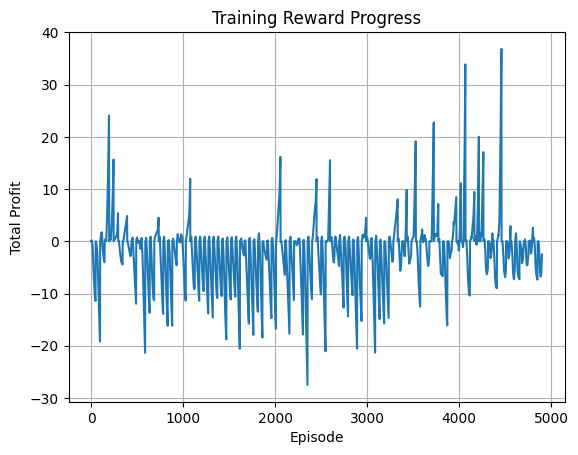

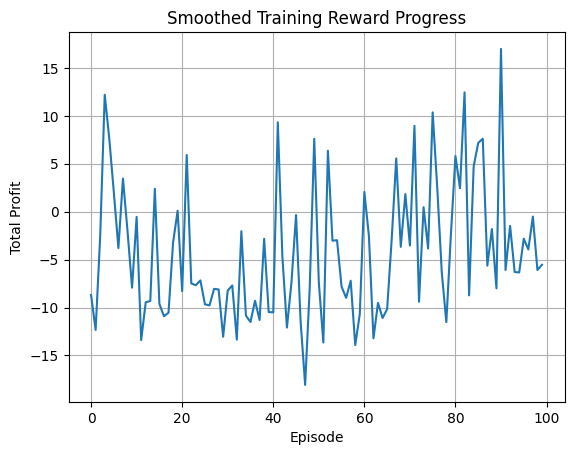

In [22]:
reporter = ReportRLPerformance(train_rewards = train_agent.rewards, train_rewards_average=train_agent.rewards_average)
reporter.plotTrainingRewardCurves()
reporter.plotsmoothedTrainingRewardCurves()

In [15]:
def foo():
    trewards = []
    for _ in range(10):
        
        treward = _ + 1
        trewards.append(treward)
        print(trewards)


foo()

[1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 4]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [16]:
t = list(range(100))
t[-20:]

[80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [17]:
df_1 = pd.DataFrame({"prices": range(100)})
df_1.rolling(10).sum().dropna()

,prices
9,45.0
10,55.0
11,65.0
12,75.0
13,85.0
...,...
95,905.0
96,915.0
97,925.0
98,935.0
